# Custom GP modeling for BO

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import torch
from xopt.vocs import VOCS

my_vocs = VOCS(
    variables = {"x":[0,1]},
    objectives = {"y":"MAXIMIZE"},
    constraints = {"c": ["LESS_THAN", 0]}
)


<Axes: >

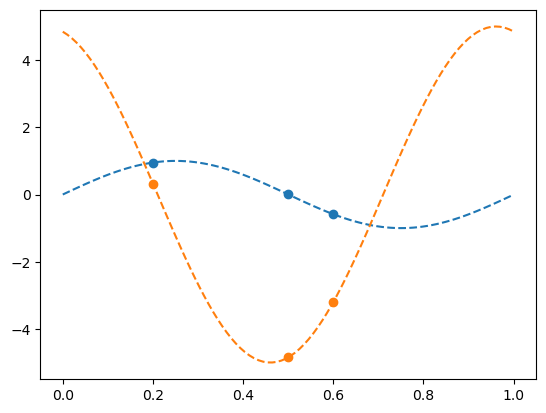

In [2]:
# define test functions
def y(x):
    return torch.sin(2*3.14*x)

def c(x):
    return 5.0*torch.cos(2*3.14*x + 0.25)

test_x = torch.linspace(*torch.tensor(my_vocs.bounds.flatten()), 100)

# define training data to pass to the generator
train_x = torch.tensor((0.2,0.5, 0.6))
train_y = y(train_x)
train_c = c(train_x)

training_data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy(), "c": train_c}
)

def plot_ground_truth():
    fig,ax = plt.subplots()
    ax.plot(test_x, y(test_x),'--C0')
    ax.plot(test_x, c(test_x),'--C1')
    ax.plot(train_x, train_y,'oC0')
    ax.plot(train_x, train_c,'oC1')

    return ax
plot_ground_truth()

# Custom kernel definition
In this example we know that the target optimization function is periodic, so it
makes sense to use a periodic kernel for the GP model with no noise. Here we define a
function to create that model.

In [3]:
from xopt.generators.bayesian.expected_improvement import ExpectedImprovementGenerator
from xopt.generators.bayesian.options import ModelOptions
from xopt.generators.bayesian.expected_improvement import BayesianOptions
from gpytorch.kernels import PeriodicKernel, ScaleKernel


# note the creation of options beforehand
# specify a periodic kernel for each output (objectives and constraints)
covar_module = ScaleKernel(PeriodicKernel())

model_options = ModelOptions(covar_modules=covar_module)
generator_options = BayesianOptions(model=model_options)
generator = ExpectedImprovementGenerator(my_vocs, options=generator_options)
generator.options

BayesianOptions(optim=OptimOptions(num_restarts=20, raw_samples=20, sequential=True, max_travel_distances=None, use_turbo=False), acq=AcqOptions(proximal_lengthscales=None, use_transformed_proximal_weights=True, monte_carlo_samples=128), model=ModelOptions(name='standard', custom_constructor=None, use_low_noise_prior=True, covar_modules=ScaleKernel(
  (base_kernel): PeriodicKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_period_length_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
), mean_modules={}), n_initial=3, use_cuda=False)

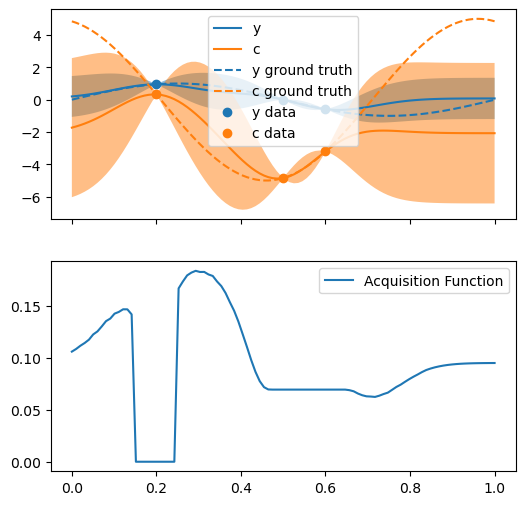

In [4]:
# view custom model from data
generator.add_data(training_data)
model = generator.train_model()

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1).double())

    for i in range(post.event_shape[-1]):
        mean = post.mean[...,i].squeeze()
        l,u = post.mvn.confidence_region()
        ax[0].plot(test_x, mean,f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].squeeze(), u[...,i].squeeze(), alpha=0.5)

    # plot ground truth
    ax[0].plot(test_x, y(test_x),'C0--', label="y ground truth")
    ax[0].plot(test_x, c(test_x),'C1--', label="c ground truth")

    # plot training data
    ax[0].plot(train_x, train_y,"C0o", label="y data")
    ax[0].plot(train_x, train_c,"C1o", label="c data")
    ax[0].legend()


    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].legend()

In [5]:
model

ModelListGP(
  (models): ModuleList(
    (0-1): 2 x SingleTaskGP(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (outcome_transform): Standardize()
      (input_transform): Normalize()
    )
  )
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
)

In [6]:
# get the next point from the generator
generator.generate(1)

,x
0,0.310283


## Custom prior mean function
Here we assume we have some knowledge of the ground truth function, which we can take
 advantage of to speed up optimization. This "prior mean" function is specified by a
 pytorch module.

In [7]:
class ConstraintPrior(torch.nn.Module):
    def forward(self, X):
        return c(X).squeeze(dim=-1)

model_options = ModelOptions(mean_modules={"c":ConstraintPrior()})
generator_options = BayesianOptions(model=model_options)
generator = ExpectedImprovementGenerator(my_vocs, options=generator_options)

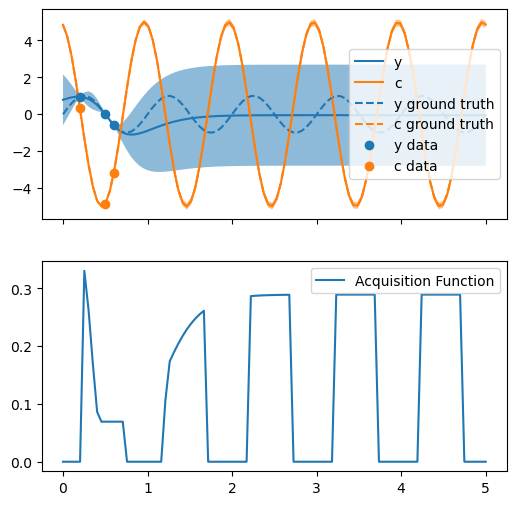

In [8]:
# view custom model from data
generator.add_data(training_data)
model = generator.train_model()
test_x = torch.linspace(0,5, 100)


fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1).double())

    for i in range(post.event_shape[-1]):
        mean = post.mean[...,i].squeeze()
        l,u = post.mvn.confidence_region()
        ax[0].plot(test_x, mean,f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].squeeze(), u[...,i].squeeze(), alpha=0.5)

    # plot ground truth
    ax[0].plot(test_x, y(test_x),'C0--', label="y ground truth")
    ax[0].plot(test_x, c(test_x),'C1--', label="c ground truth")

    # plot training data
    ax[0].plot(train_x, train_y,"C0o", label="y data")
    ax[0].plot(train_x, train_c,"C1o", label="c data")
    ax[0].legend()


    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].legend()

In [9]:
model

ModelListGP(
  (models): ModuleList(
    (0): SingleTaskGP(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): MaternKernel(
          (lengthscale_prior): GammaPrior()
          (raw_lengthscale_constraint): Positive()
        )
        (outputscale_prior): GammaPrior()
        (raw_outputscale_constraint): Positive()
      )
      (outcome_transform): Standardize()
      (input_transform): Normalize()
    )
    (1): SingleTaskGP(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): CustomMean(
        (model): ConstraintPrior()
        (input_transformer): Normalize()
        (outcome_tra

In [10]:
list(model.named_parameters())

[('models.0.likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-21.4145], dtype=torch.float64, requires_grad=True)),
 ('models.0.mean_module.raw_constant',
  Parameter containing:
  tensor(-0.2222, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.raw_outputscale',
  Parameter containing:
  tensor(3.0727, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.7308]], dtype=torch.float64, requires_grad=True)),
 ('models.1.covar_module.raw_outputscale',
  Parameter containing:
  tensor(-6.7634, dtype=torch.float64, requires_grad=True)),
 ('models.1.covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.5597]], dtype=torch.float64, requires_grad=True))]